In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from datasets import load_dataset
import matplotlib.pyplot as plt
%matplotlib inline


torch.manual_seed(12046)

In [2]:
# 一些超参数
learning_rate = 1e-3
eval_iters = 10
batch_size=1000
sequence_len=64
# 如果有GPU，该脚本将使用GPU进行计算
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
raw_datasets = load_dataset("Nan-Do/code-search-net-python")
datasets = raw_datasets['train'].filter(lambda x: 'apache/spark' in x['repo'])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

(…)-00000-of-00004-ee77a7de79eb2ab2.parquet:   0%|          | 0.00/155M [00:00<?, ?B/s]

(…)-00001-of-00004-648b3bede2edf6e6.parquet:   0%|          | 0.00/139M [00:00<?, ?B/s]

(…)-00002-of-00004-1dfd72b171e6b205.parquet:   0%|          | 0.00/153M [00:00<?, ?B/s]

(…)-00003-of-00004-184ab6d0e3c690b1.parquet:   0%|          | 0.00/151M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/455243 [00:00<?, ? examples/s]

Filter:   0%|          | 0/455243 [00:00<?, ? examples/s]

In [4]:
class CharTokenizer:

    def __init__(self, data, end_ind=0):
        # data: list[str]
        # 得到所有的字符
        chars = sorted(list(set(''.join(data))))
        self.char2ind = {s: i + 1 for i, s in enumerate(chars)}
        self.char2ind['<|e|>'] = end_ind
        self.ind2char = {v: k for k, v in self.char2ind.items()}
        self.end_ind = end_ind

    def encode(self, x):
        # x: str
        return [self.char2ind[i] for i in x]

    def decode(self, x):
        # x: int or list[x]
        if isinstance(x, int):
            return self.ind2char[x]
        return [self.ind2char[i] for i in x]

tokenizer = CharTokenizer(datasets['original_string'])

In [5]:
test_str = 'def f(x):'
re = tokenizer.encode(test_str)
print(re)
''.join(tokenizer.decode(range(len(tokenizer.char2ind))))

[70, 71, 72, 2, 72, 10, 90, 11, 28]


'<|e|>\n !"#$%&\'()*+,-./0123456789:;<=>?@ABCDEFGHIJKLMNOPQRSTUVWXYZ[\\]^_`abcdefghijklmnopqrstuvwxyz{|}~ö'

In [6]:
class RNN(nn.Module):
  def __init__(self, input_size, hidden_size):
    super().__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.i2h = nn.Linear(input_size + hidden_size, hidden_size)

  def forward(self, input, hidden=None):
    # input (B, T, C)
    # hidden (B,  H)
    # out (B, T, H)
    B, T, C = input.shape
    re = []
    if hidden is None:
      hidden = self.init_hidden(B, input.device)
    for i in range(T):
      combined = torch.concat((input[:, i, :], hidden), dim=-1) # (B, C+H)
      hidden = self.i2h(combined) # (B, H)
      re.append(hidden)
    return torch.stack(re, dim=1) # (B, T, H)

  def init_hidden(self, B, device):
    return torch.zeros((B, self.hidden_size), device=device)

In [7]:
r = RNN(3, 4)
x = torch.randn(5, 2, 3)
r(x).shape

torch.Size([5, 2, 4])

In [8]:
class CharRNNBatch(nn.Module):
  def __init__(self, vs):
    super().__init__()
    emb_size = 256
    hidden_size = 128
    self.emb = nn.Embedding(vs, emb_size)
    self.rnn1 = RNN(emb_size, hidden_size)
    self.ln1 = nn.LayerNorm(hidden_size)
    self.rnn2 = RNN(hidden_size, hidden_size)
    self.ln2 = nn.LayerNorm(hidden_size)
    self.lm = nn.Linear(hidden_size, vs)
    self.dp = nn.Dropout(0.4)

  def forward(self, x):
    # x : (B, T)
    B = x.shape[0]
    embeddings = self.emb(x)  # (B, T, C)
    h = F.relu(self.ln1(self.rnn1(embeddings))) # (B, T， H)
    h = self.dp(h)
    h = F.relu(self.ln2(self.rnn2(h)))      # (B, T, hidden_size)
    h = self.dp(h)
    out = self.lm(h)    # (B, T, vs)
    return out

In [9]:
c_model = CharRNNBatch(len(tokenizer.char2ind)).to(device)
c_model

CharRNNBatch(
  (emb): Embedding(98, 256)
  (rnn1): RNN(
    (i2h): Linear(in_features=384, out_features=128, bias=True)
  )
  (ln1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (rnn2): RNN(
    (i2h): Linear(in_features=256, out_features=128, bias=True)
  )
  (ln2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (lm): Linear(in_features=128, out_features=98, bias=True)
  (dp): Dropout(p=0.4, inplace=False)
)

In [10]:
@torch.no_grad()
def generate(model, context, tokenizer, max_new_tokens=300):
  # context : (1, T)
  out = context.tolist()[0]
  model.eval()
  for _ in range(max_new_tokens):
    logits = model(context)   # (1, T, vs98)
    probs = F.softmax(logits[:, -1, :], dim=-1) # (1, vs98)
    # 随机生成文本
    ix = torch.multinomial(probs, num_samples=1) # (1, 1)
    # 更新背景
    context = torch.concat((context, ix), dim=-1)
    out.append(ix.item())
    if out[-1] == tokenizer.end_ind:
      break
  model.train()
  return out

In [11]:
context = torch.tensor(tokenizer.encode('def'), device=device).unsqueeze(0)
print(''.join(tokenizer.decode(generate(c_model, context, tokenizer))))

def*ZK(F/R|("YP`B<ö G|uw,R<1'L$=s9NNs{KQ=CK"AM:iKRaR;+Q3j<sAjgWö$M0Nx!q9T3jyMö5Za)'s~5\rm&B"({Y
c"vMR^DAx1zk@D@*N,*"jIT'~5HciGbYo.Qj!D_O_G;_8|]!lR#`p=H4zV$k4ucbBM{s+K$vcYt;"MqE+/zG^K~>A8'{]^<Fi"R]"ö+/5N)^-.V16ZMahösTöv>1)C,e44T{
`Z\[DKWFp`K"omF^3drBZ70TqbyUH+bk71c^&GG%04$bm{og$O5+:A_JT49b{pB\rob&oJnJuk


In [12]:
def process(data, tokenizer, sequence_len=sequence_len):
  text = data['original_string']
  # text is list[str]
  inputs, labels = [], []
  for t in text:
    enc = tokenizer.encode(t)
    enc += [tokenizer.end_ind]
    for i in range(len(enc) - sequence_len):
      inputs.append(enc[i : i+sequence_len])
      labels.append(enc[i+1 : i+1+sequence_len])
  return {'inputs' : inputs, 'labels' : labels}

In [14]:
tokenized

DatasetDict({
    train: Dataset({
        features: ['inputs', 'labels'],
        num_rows: 611566
    })
    test: Dataset({
        features: ['inputs', 'labels'],
        num_rows: 54428
    })
})

In [15]:
train_loader = DataLoader(tokenized['train'], batch_size=batch_size, shuffle=True)
test_loader = DataLoader(tokenized['test'], batch_size=batch_size, shuffle=True)

In [16]:
next(iter(train_loader))

{'inputs': tensor([[ 2,  2, 69,  ...,  2,  2,  2],
         [80, 73, 71,  ..., 80,  2, 84],
         [70, 71, 72,  ..., 40, 75, 80],
         ...,
         [69, 74, 71,  ...,  2,  2,  2],
         [ 2,  2,  2,  ...,  2,  2, 75],
         [36, 75, 85,  ...,  2,  2, 84]], device='cuda:0'),
 'labels': tensor([[ 2, 69, 78,  ...,  2,  2,  2],
         [73, 71, 10,  ...,  2, 84, 71],
         [71, 72,  2,  ..., 75, 80, 70],
         ...,
         [74, 71, 16,  ...,  2,  2,  2],
         [ 2,  2,  2,  ...,  2, 75, 80],
         [75, 85, 71,  ...,  2, 84, 67]], device='cuda:0')}

In [17]:
def estimate_loss(model):
  re = {}
  # 将模式切换至评估模式
  model.eval()
  re['train'] = _loss(model, train_loader)
  re['test'] = _loss(model, test_loader)
  # 将模型切换至训练模式
  model.train()
  return re


def _loss(model, data_loader):
  loss = []
  data_iter = iter(data_loader)

  # 随机使用多个批量数据来评估模型效果
  for k in range(eval_iters):
    data = next(data_iter)
    if data is None:
      data_iter = iter(data_loader)
      data = next(data_iter)
    inputs, labels = data['inputs'], data['labels'] # (B, T)
    logits = model(inputs) # (B, T, vs)
    loss.append(F.cross_entropy(logits.transpose(-2, -1), labels).item())
  return torch.tensor(loss).mean().item()

In [18]:
estimate_loss(c_model)

{'train': 4.80492639541626, 'test': 4.802587985992432}

In [ ]:
def train_model(model, optimizer, epochs=10):
  lossi = []
  for epoch in range(epochs):
    for i, data in enumerate(train_loader, 0):
      inputs, labels = data['inputs'], data['labels'] # (B, T)
      logits = model(inputs) # (B, T, vs)
      optimizer.zero_grad()
      loss = F.cross_entropy(logits.transpose(-2, -1), labels)
      lossi.append(loss.item())
      loss.backward()
      optimizer.step()
    # 评估模型，并输出结果
    stats = estimate_loss(model)
    train_loss = f'train loss {stats["train"]:.4f}'
    test_loss = f'test loss {stats["test"]:.4f}'
    print(f'epoch {epoch:>2}: {train_loss}, {test_loss}')
  return lossi


In [20]:
l = train_model(c_model, optim.Adam(c_model.parameters(), lr=learning_rate))

epoch 10: train loss 1.5236, test loss 1.6400
epoch 10: train loss 1.3957, test loss 1.5197
epoch 10: train loss 1.3378, test loss 1.4751
epoch 10: train loss 1.3159, test loss 1.4483
epoch 10: train loss 1.2866, test loss 1.4298
epoch 10: train loss 1.2772, test loss 1.4225
epoch 10: train loss 1.2669, test loss 1.4018
epoch 10: train loss 1.2468, test loss 1.3972
epoch 10: train loss 1.2511, test loss 1.3956
epoch 10: train loss 1.2435, test loss 1.3900


In [21]:
context = torch.tensor(tokenizer.encode('def'), device=device).unsqueeze(0)
print(''.join(tokenizer.decode(generate(c_model, context, tokenizer))))

def chary eechope thin C2seing. in not of the usingbatch jowsPartitions.
        """
            partitioner to to as
                     in. Pandas is is None: the format for the value, as of outpen loimestors)):
            sist = trof a
    sumders=storage())
        return the topled with deobj _c


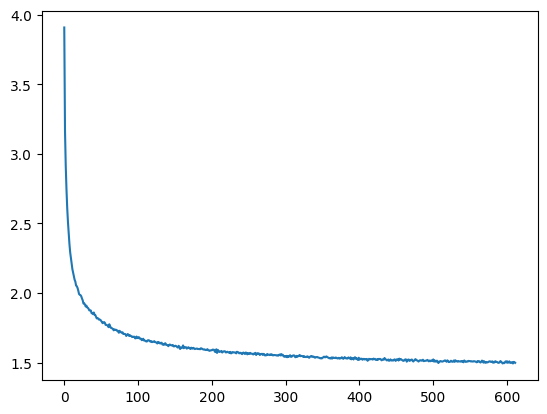

In [22]:
plt.plot(torch.tensor(l).view(-1, 10).mean(dim=-1))